In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

For all data taken on 2024/08/23, the scans are of the A-D laser at 787 nm in the FSR where 0 MHz corresponds to roughly -1.3 GHz detuned from the wavemeter reference. 250 data points were taken, corresponding to a continuous scan in the FSR from 0 MHz to 500 MHz.

From the transverse Doppler-free scans, the "zero velocity" reference is at 420 MHz.

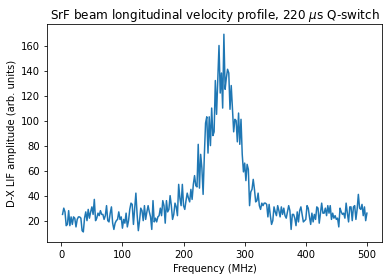

In [2]:
#example of plotting one of the profiles (220 us Q-switch time)
df = pd.read_csv("20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-220QSwitch.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
counts_no_slowing = df['count'].to_numpy()
indices_no_slowing = df['index'].to_numpy()
freqs = 2*indices_no_slowing
#counts_no_slowing = np.mean(counts_no_slowing.reshape([-1, 5]), axis=1)

plt.xlabel("Frequency (MHz)")
plt.ylabel("D-X LIF amplitude (arb. units)")
plt.title("SrF beam longitudinal velocity profile, 220 $\mu$s Q-switch")
plt.plot(freqs, counts_no_slowing)
plt.show()


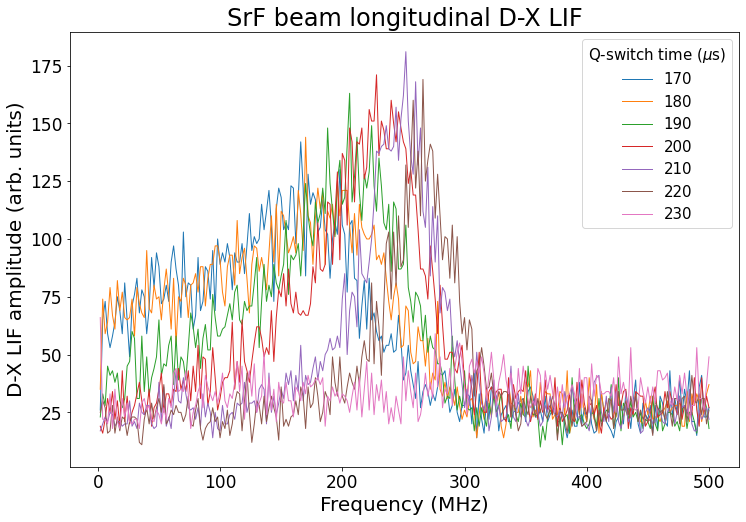

In [3]:
#now plot all the profiles for different Q switch times altogether (still in frequency units)

QSwitchTimes = [170, 180, 190, 200, 210, 220, 230]
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)

for i in range(len(QSwitchTimes)):
    df = pd.read_csv(f"20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-{QSwitchTimes[i]}QSwitch.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
    counts = df['count'].to_numpy()
    indices = df['index'].to_numpy()
    freqs = 2*indices_no_slowing
    plt.plot(freqs, counts, linewidth=1.0)

plt.xlabel("Frequency (MHz)", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("SrF beam longitudinal D-X LIF", fontsize=24)
plt.legend(QSwitchTimes, title="Q-switch time ($\mu$s)", title_fontsize=15, fontsize=15)
#plt.savefig("20240823/SrF_beam_longitudinal_velocity_profile.png")
plt.show()

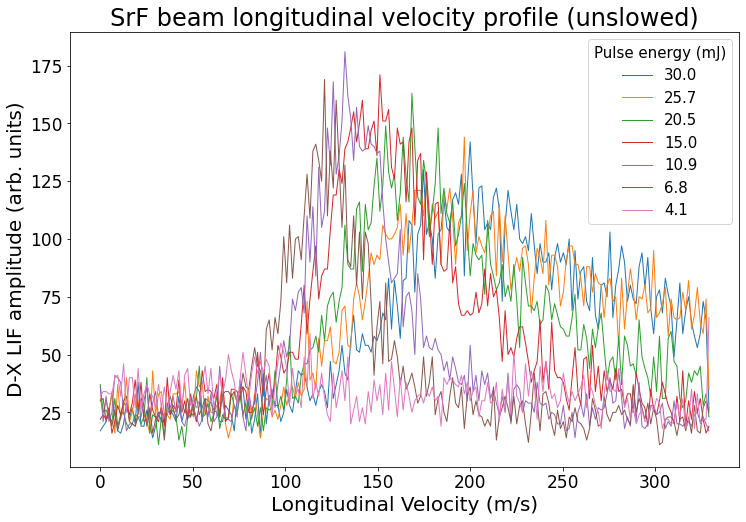

In [4]:
#plot LVP with different Q switch times, but also convert to velocity units and pulse energy

QSwitchTimes = [170, 180, 190, 200, 210, 220, 230]
PulseEnergy = [30.0, 25.7, 20.5, 15.0, 10.9, 6.8, 4.1]
zerovelocity_ref = 420.0 #in MHz
wavelen = 0.787 #in microns
velocities = (zerovelocity_ref - freqs)*wavelen

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
for i in range(len(QSwitchTimes)):
    df = pd.read_csv(f"20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-{QSwitchTimes[i]}QSwitch.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
    counts = df['count'].to_numpy()
    indices = df['index'].to_numpy()
    freqs = 2*indices_no_slowing
    plt.plot(velocities[velocities>=0], counts[velocities>=0], linewidth=1.0)

plt.xlabel("Longitudinal Velocity (m/s)", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("SrF beam longitudinal velocity profile (unslowed)", fontsize=24)
plt.legend(PulseEnergy, title="Pulse energy (mJ)", title_fontsize=15, fontsize=15)
#plt.savefig("20240823/SrF_beam_lvp_all_unslowed.png", dpi=300)
plt.show()


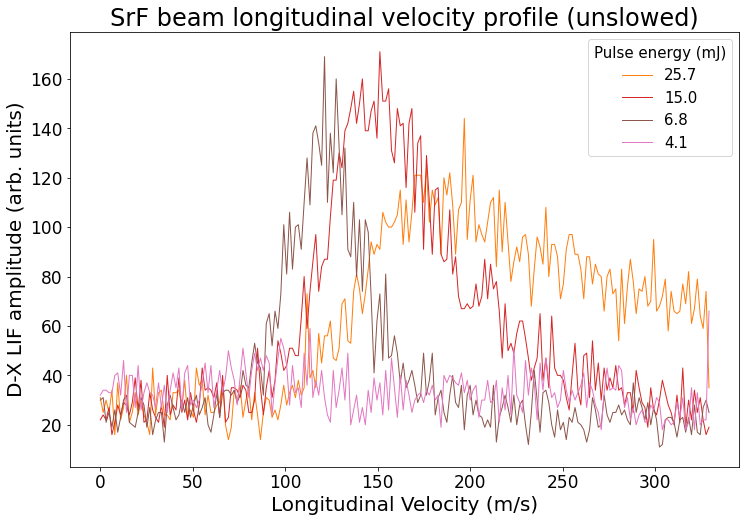

In [5]:
#same plot of LVP but have less Q switch times for clarity

QSwitchTimes = [180, 200, 220, 230]
colors = ["#ff7f0e", "#d62728", "#8c564b", "#e377c2"]
PulseEnergy = [25.7, 15.0, 6.8, 4.1]
zerovelocity_ref = 420.0 #in MHz
wavelen = 0.787 #in microns
velocities = (zerovelocity_ref - freqs)*wavelen

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
for i in range(len(QSwitchTimes)):
    df = pd.read_csv(f"20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-{QSwitchTimes[i]}QSwitch.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
    counts = df['count'].to_numpy()
    indices = df['index'].to_numpy()
    freqs = 2*indices_no_slowing
    plt.plot(velocities[velocities>=0], counts[velocities>=0], linewidth=1.0, color=colors[i])

plt.xlabel("Longitudinal Velocity (m/s)", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("SrF beam longitudinal velocity profile (unslowed)", fontsize=24)
plt.legend(PulseEnergy, title="Pulse energy (mJ)", title_fontsize=15, fontsize=15)
#plt.savefig("20240823/SrF_beam_lvp_select_unslowed.png", dpi=300)
plt.show()

[224.34780964824228, 215.01698953188435, 184.6728275763192, 159.8389718338832, 138.3361412811617, 122.83102702362945]
[209.58198980129742, 226.92691645598626, 169.90532418898474, 139.43124898820105, 85.367306620774, 87.48466987333227]


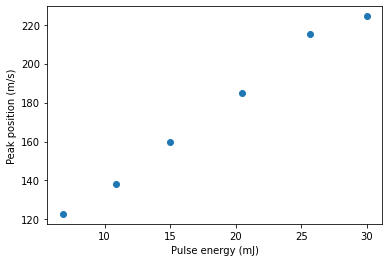

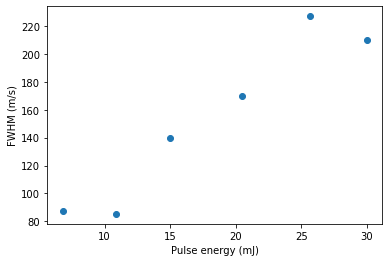

In [6]:
#now fit all LVPs with a Gaussian and extract peak position and FWHM

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def gaussian(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))

QSwitchTimes = [170, 180, 190, 200, 210, 220]
PulseEnergy = [30.0, 25.7, 20.5, 15.0, 10.9, 6.8]
zerovelocity_ref = 420.0 #in MHz
wavelen = 0.787 #in microns
velocities = (zerovelocity_ref - freqs)*wavelen


peak_positions = []
FWHMs = []

for i in range(len(QSwitchTimes)):
    df = pd.read_csv(f"20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-{QSwitchTimes[i]}QSwitch.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
    counts = df['count'].to_numpy()
    indices = df['index'].to_numpy()
    freqs = 2*indices_no_slowing
    velocities = (zerovelocity_ref - freqs)*wavelen
    popt, pcov = curve_fit(gaussian, velocities[velocities>=0], counts[velocities>=0], p0=[np.max(counts), 0.0, 1.0])
    #plt.plot(velocities[velocities>=0], counts[velocities>=0], linewidth=1.0)
    #plt.plot(velocities[velocities>=0], gaussian(velocities[velocities>=0], *popt), 'r--', linewidth=1.0)
    peak_positions.append(popt[1])
    FWHMs.append(2.355*popt[2])

#plt.show()
print(peak_positions)
print(FWHMs)

#plot peak position and FWHM as a function of pulse energy

plt.plot(PulseEnergy, peak_positions, 'o')
plt.xlabel("Pulse energy (mJ)")
plt.ylabel("Peak position (m/s)")
plt.show()

plt.plot(PulseEnergy, FWHMs, 'o')
plt.xlabel("Pulse energy (mJ)")
plt.ylabel("FWHM (m/s)")
plt.show()

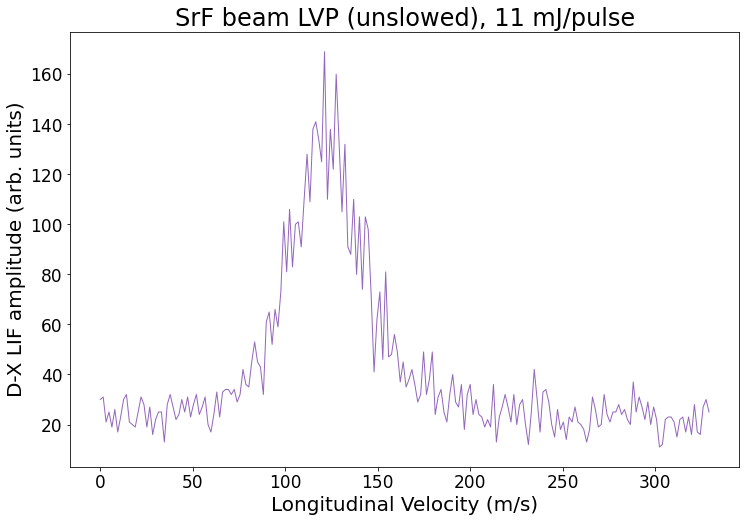

In [7]:
#plot just the LVP for 210 us Q-switch time

df = pd.read_csv("20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-210QSwitch.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
counts_no_slowing = df['count'].to_numpy()
indices_no_slowing = df['index'].to_numpy()
freqs = 2*indices_no_slowing
zerovelocity_ref = 420.0 #in MHz
wavelen = 0.787 #in microns
velocities = (zerovelocity_ref - freqs)*wavelen

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(velocities[velocities>=0], counts[velocities>=0], linewidth=1.0, color="#9467bd")

plt.xlabel("Longitudinal Velocity (m/s)", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("SrF beam LVP (unslowed), 11 mJ/pulse", fontsize=24)
#plt.legend(PulseEnergy, title="Pulse energy (mJ)", title_fontsize=15, fontsize=15)
#plt.savefig("20240823/SrF_beam_lvp_11mJ_unslowed.png", dpi=300)
plt.show()



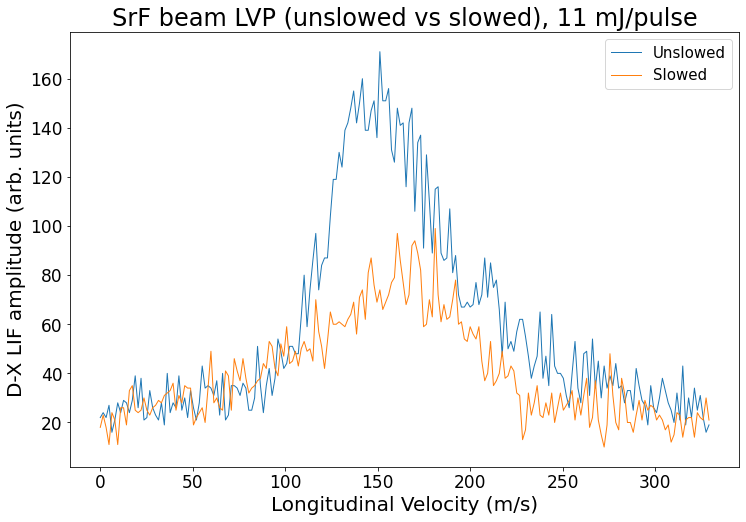

In [8]:
#now plot unslowed vs slowed LVP for Q-switch time of 200 us
zerovelocity_ref = 420.0 #in MHz
wavelen = 0.787 #in microns
velocities = (zerovelocity_ref - freqs)*wavelen

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
df_noslowing = pd.read_csv(f"20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-200QSwitch.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
counts_no_slowing = df_noslowing['count'].to_numpy()
indices_no_slowing = df_noslowing['index'].to_numpy()
freqs = 2*indices_no_slowing
zerovelocity_ref = 420.0 #in MHz
wavelen = 0.787 #in microns
velocities_no_slowing = (zerovelocity_ref - freqs)*wavelen
plt.plot(velocities_no_slowing[velocities>=0], counts_no_slowing[velocities>=0], linewidth=1.0, label="Unslowed")

df_withslowing = pd.read_csv("20240823/787nmLongScan2MHzStepFrom0MHz1GHzRed-200QSwitch-WithSlowing.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
counts_with_slowing = df_withslowing['count'].to_numpy()
indices_with_slowing = df_withslowing['index'].to_numpy()
freqs = 2*indices_with_slowing
velocities_with_slowing = (zerovelocity_ref - freqs)*wavelen
plt.plot(velocities_with_slowing[velocities>=0], counts_with_slowing[velocities>=0], linewidth=1.0, label="Slowed")

plt.xlabel("Longitudinal Velocity (m/s)", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("SrF beam LVP (unslowed vs slowed), 11 mJ/pulse", fontsize=24)
plt.legend(fontsize=15)
#plt.savefig("20240823/SrF_beam_lvp_11mJ_slowed_vs_unslowed.png", dpi=300)
plt.show()

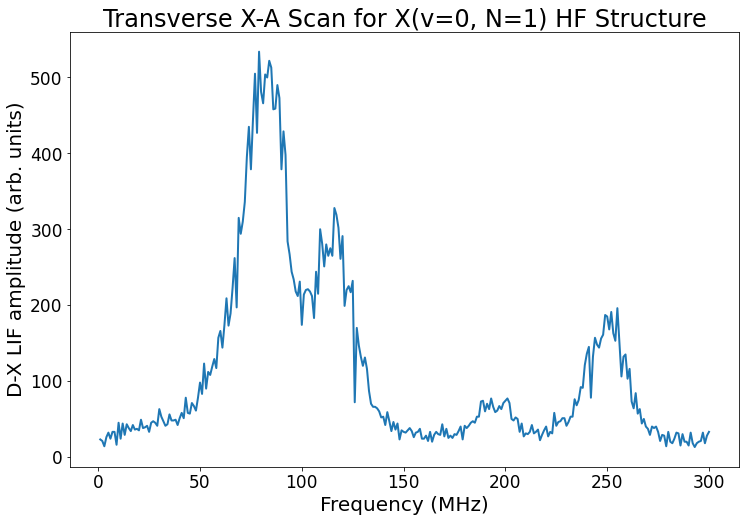

In [9]:
#replot the transverse X-A and A-D hyperfine scan

df = pd.read_csv("Prior to 20240822/1MHzStepHFScan.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)

counts_no_slowing = df['count'].to_numpy()
indices_no_slowing = df['index'].to_numpy()
plt.xlabel("Frequency (MHz)", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("Transverse X-A Scan for X(v=0, N=1) HF Structure", fontsize=24)
plt.plot(indices_no_slowing, counts_no_slowing, linewidth=2.0)
#plt.savefig("Prior to 20240822/X(v0N1)HF_scan.png", dpi=300)
plt.show()


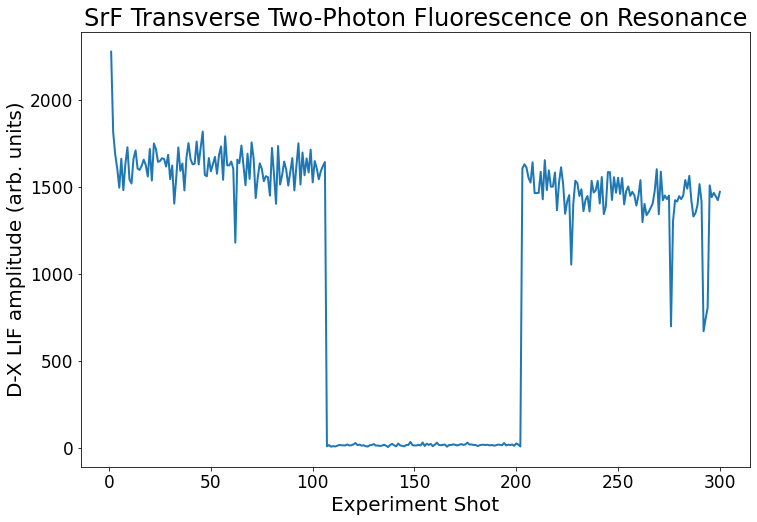

In [10]:
#look for some other scans

df = pd.read_csv("Prior to 20240822/TransverseOnResonanceNoScan300Shots.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)

counts_no_slowing = df['count'].to_numpy()
indices_no_slowing = df['index'].to_numpy()
plt.xlabel("Experiment Shot", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("SrF Transverse Two-Photon Fluorescence on Resonance", fontsize=24)
plt.plot(indices_no_slowing, counts_no_slowing, linewidth=2.0)
#plt.savefig("Prior to 20240822/TransverseNoScanExample.png", dpi=300)
plt.show()

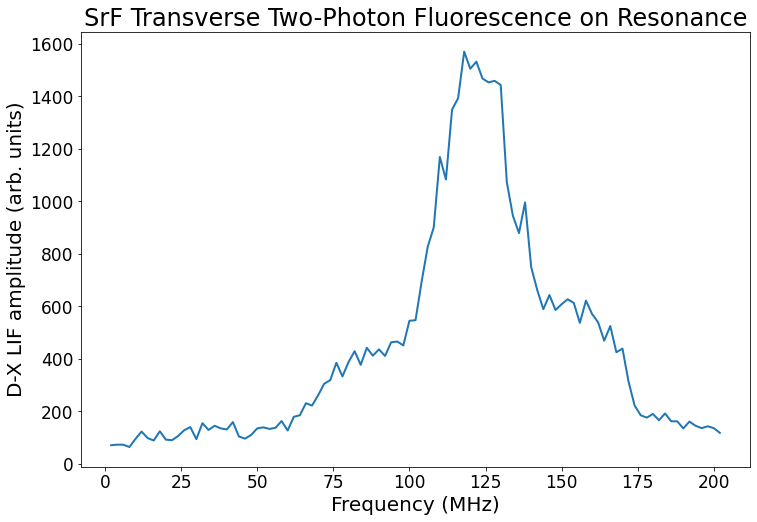

In [11]:
#look for some other scans

df = pd.read_csv("20240822/787nmTransScan2MHzStep1GHzRed-2.txt", skiprows=8, names=['index', 'count', 'rate'], delimiter=', ', engine='python')
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)

counts_no_slowing = df['count'].to_numpy()
indices_no_slowing = df['index'].to_numpy()
plt.xlabel("Frequency (MHz)", fontsize=20)
plt.ylabel("D-X LIF amplitude (arb. units)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.title("SrF Transverse Two-Photon Fluorescence on Resonance", fontsize=24)
plt.plot(indices_no_slowing*2, counts_no_slowing, linewidth=2.0)
#plt.savefig("20240822/TransverseScanExample.png", dpi=300)
plt.show()